# COMP47670 Assignment 2: Flight Delay Analysis
This notebook contains all tasks associated with COMP47670 Data Science in Python Assignment 2.

## Task 1: Data Preperation & Characterisation 

### Dataset Combination

In [1]:
# Import Necessary Libraries
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Load Flight Data into a pandas DataFrame
scheduled_flights_info = pd.read_csv("data/flights_schedule.csv")
# Load weather conditions into a pandas DataFrame
weather_condition_df = pd.read_csv("data/flight_conditions_outcomes.csv")
# Merge the two dataframes on "flight_id" column
flight_info_df = pd.merge(weather_condition_df, scheduled_flights_info, how="inner", on="flight_id")

### Data Cleaning
For each column in the DataFrame lets:
- Verify input is uniform.
- Convert to an appropriate data type.

In [3]:
# Print datatypes for each dataframe column.
flight_info_df.dtypes

flight_id         object
precipitation     object
wind              object
dep_delay          int64
flight_date       object
sched_dep_time    object
sched_arr_time    object
carrier_code      object
carrier           object
flight_number     object
origin            object
origin_name       object
origin_city       object
origin_country    object
dest              object
dest_name         object
dest_city         object
dest_country      object
distance_km        int64
aircraft_type     object
dtype: object

#### flight_id
This is the unique identifier for each flight in the dataset. Each entry should be stored as a string data type.

In [4]:
# Convert all entries to a string data type
flight_info_df["flight_id"] = flight_info_df["flight_id"].astype("string")

#### precipitation
This column contains categorical data refering to the precipitation on the day of each flight. Entries in this column take the following format:
- "Dry"
- "Light"
- "Moderate"
- "Heavy"

Since these categories have a natural order of precipitation intensity, lets convert entries to the following:

- Dry -> 0
- Light -> 1
- Moderate -> 2
- Heavy -> 3

In [5]:
# Define a precipitation mapping dictionary
precipitation_mapping = {"Dry" : 0, "Light": 1, "Moderate": 2, "Heavy" : 3}

# Apply the precipitation mapping dictionary.
flight_info_df["precipitation"] = flight_info_df["precipitation"].map(precipitation_mapping)

#### wind
This column contains categorical data regarding the wind on the day of each flight. Lets perform the same preprocessing as the "precipitation" column. Entries in the column are of the following format:
- Calm
- Breezy
- Windy
- VeryWindy
  
Since there is a natual order of wind intensity lets convert entries to the following:
- Calm -> 0
- Breezy -> 1
- Windy -> 2
- VeryWindy -> 3 

In [6]:
# Define a wind intensity mapping dictionary
wind_intensity_mapping = {"Calm" : 0, "Breezy" : 1, "Windy" : 2, "VeryWindy" : 3}

# Apply mapping dictionary
flight_info_df["wind"] = flight_info_df["wind"].map(wind_intensity_mapping)

#### dep_delay

This column contains the departure delay of each flight in minutes. Entries in this column are already of data type int so no preprocessing is required.

In [7]:
flight_info_df["dep_delay"].dtype

dtype('int64')

#### flight_date, sched_dep_time, sched_arr_time

Lets merge flight_date and sched_dep_time into a new column called scheduled_departure which is will be populated with DateTime objects. Lets also merge flight_date  with sched_arr_time into a new column called scheduled_arrival which is will be populated with DateTime objects. 

It's important to note that if a flight takes of before midnight and lands after, we will need to add 1 day to the entry in the scheduled_arrival column.

In [8]:
# Create departure datetime
departure_dt = pd.to_datetime(
    flight_info_df["flight_date"] + " " + flight_info_df["sched_dep_time"],
    format="%Y-%m-%d %H:%M",
    errors="coerce"
)

# Create arrival datetime (initially same date)
arrival_dt = pd.to_datetime(
    flight_info_df["flight_date"] + " " + flight_info_df["sched_arr_time"],
    format="%Y-%m-%d %H:%M",
    errors="coerce"
)

# Correct overnight flights
arrival_dt_corrected = arrival_dt.where(arrival_dt >= departure_dt, arrival_dt + pd.Timedelta(days=1))

# Save to dataframe
flight_info_df["scheduled_departure"] = departure_dt
flight_info_df["scheduled_arrival"] = arrival_dt_corrected


The columns flight_date, sched_dep_time, and sched_arr_time are now no longer needed, so lets remove them from our dataframe.

In [9]:
# Define a list of columns to drop
columns_to_drop = ["flight_date","sched_dep_time","sched_arr_time"]

# Drop the columns from the dataframe
flight_info_df = flight_info_df.drop(columns_to_drop, axis=1)

#### carrier_code

This column contains a two digit code representing the airline operating each flight in the dataset. This column is redundent since the column "carrier_code" also exists in the dataframe representing the airline operating each flight. Lets now drop the "carrier_code" column from the dataframe.

In [10]:
# Drop column from the DataFrame
flight_info_df = flight_info_df.drop("carrier_code", axis=1)

#### carrier

This column represents the airline operating each flight in the dataset. Lets convert all entries to a string data type.

In [11]:
# Convert entries to a string data type 
flight_info_df["carrier"] = flight_info_df["carrier"].astype("string")

#### flight_number

This column contains identification information about each flight in the dataset. Since this column is not a unique identifier for each flight, this descriptive feature doesn't serve any purpose in the context of predicting flight delays. Lets nows remove this column from our DataFrame.

In [12]:
# Drop column from the DataFrame
flight_info_df = flight_info_df.drop("flight_number", axis=1)

#### origin

This column contains information about the origin of each flight in the dataset. Each entry is a three letter code perpresenting the city the flight departs from. The column "origin_name" already exists in the dataframe and is comprised of a more complete description of origin location. Since we have two columns describing the same thing lets remove the "origin" column in favour of the "origin_name" column. 

In [13]:
# Drop column from the DataFrame
flight_info_df = flight_info_df.drop("origin", axis=1)

#### origin_name

This column contains descriptive information about the origin airport of each flight in the dataset. Lets convert each entry into a string data type.

In [14]:
# Convert entries to a string data type
flight_info_df["origin_name"] = flight_info_df["origin_name"].astype("string")

#### origin_city

This column contains descriptive information about the origin city of each flight in the dataset. Lets convert each entry into a string data type.

In [15]:
# Convert entries to a string data type
flight_info_df["origin_city"] = flight_info_df["origin_city"].astype("string")

#### origin_country

This column contains descriptive information about the origin county of each flight in the dataset. Lets convert each entry into a string data type.

In [16]:
# Convert entries to a string data type
flight_info_df["origin_country"] = flight_info_df["origin_country"].astype("string")

#### dest

This columns is similiar to the "origin" column that was removed earlier. This column contains a three letter description of the destination of each flight in the dataset. It is safe to remove this column in favour of the "dest_name" column which provides a richer description of destination location.

In [17]:
# Drip "dest" column from the dataframe
flight_info_df = flight_info_df.drop("dest",axis=1) 

#### dest_name

This column provides a description of the destination airport of each flight in the dataset. Lets convert each entry to a string data type.

In [18]:
# Convert entries to a string data type
flight_info_df["dest_name"] = flight_info_df["dest_name"].astype("string")

#### dest_city

This column provides a description of the destination city of each flight in the dataset. Lets convert each entry to a string data type.

In [19]:
# Convert entries to a string data type
flight_info_df["dest_city"] = flight_info_df["dest_city"].astype("string")

#### dest_country

This column provides a description of the destination country of each flight in the dataset. Lets convert each entry to a string data type.

In [20]:
# Convert entries to a string data type
flight_info_df["dest_country"] = flight_info_df["dest_country"].astype("string")

#### distance_km

This column provides a description of the distance of each flight in the dataset in kilometers. Each entry is already converted to an integer data type so no preprocessing is necessary for this column.

In [21]:
flight_info_df["distance_km"].dtype

dtype('int64')

#### aircraft_type

This column provides a categorical description of the aircraft type of each flight in the dataset. Lets convert each entry to a string data type.

In [22]:
# Convert entries to a string data type
flight_info_df["aircraft_type"] = flight_info_df["aircraft_type"].astype("string")

### Derived Features

Now that the original dataset has been preprocessed, it is important to derive features that will enhance the classification algorithms. This section will outline a number of derived features that will be added to the dataframe and why they will be useful.

#### 1. Binary Classification of Delay

Lets assume any flight with a value of "dep_delay" >= 15 to be delayed. Lets create a binary classification for this outcome and add it to the dataframe.

In [23]:
# Create a new column called "delayed".
# If the value for "dep_delay" >= 15 then the flight will be classified as delayed.
# A value of 1 will be added to the "delayed" column.

# If the value for "dep_delay" < 15 then the flight will be classified as not delayed.
# A value of 0 will be added to the "delayed" column.

flight_info_df["delayed"] = (flight_info_df["dep_delay"] >= 15).astype(int)

####  2. Time-Based Features from Scheduled Departures

My intuition leads me to believe that time of day, day of the week, and possible month of the year could be strong predictors of delays. Lets create 3 new columns:
- departure_hour
- departure_day
- departure_month

In [24]:
# Create new column with the hour of day for the scheduled departure.
flight_info_df["departure_hour"] = flight_info_df["scheduled_departure"].dt.hour

# Create new column with the day of week for the scheduled departure.
flight_info_df["departure_dayofweek"] = flight_info_df["scheduled_departure"].dt.dayofweek

# Create new column with the month of year for the scheduled departure.
flight_info_df["departure_month"] = flight_info_df["scheduled_departure"].dt.month

#### 3. Flight Duration

Lets compute the flight duration in minutes and add it as its own column to the dataframe.

In [25]:
# Handle next-day arrivals
arrival_adjusted = flight_info_df["scheduled_arrival"].where(
    flight_info_df["scheduled_arrival"] >= flight_info_df["scheduled_departure"],
    flight_info_df["scheduled_arrival"] + pd.Timedelta(days=1)
)

# Calculate flight duration in minutes
flight_info_df["flight_duration_mins"] = (
    (arrival_adjusted - flight_info_df["scheduled_departure"])
    .dt.total_seconds() / 60
)

#### 4. Weather Condition Encoding

It might also be useful to add a "bad_weather" flag. Lets say the weather is "bad" if the precipitation level or wind level is greater than or equal to 2. 

In [26]:
# If the values in the "precipitation" or "wind" columns are >= 2 then the "bad_weather" flag will
# be set to 1, 0 otherwise.

flight_info_df["bad_weather"] = ((flight_info_df["precipitation"] >= 2) |
                                 (flight_info_df["wind"]  >= 2)).astype(int)

#### 5. Origin Flight Count

Lets add the total number of flight that are scheduled to depart from the departure airport for each flight in the dataset.

In [27]:
# Add a flight count column per departure airport
flight_info_df["origin_flight_count"] = flight_info_df.groupby("origin_name")["flight_id"].transform("count")

#### 6. Peak Traffic Indicators

Lets define the peak traffic times as 6-9 am and 4-7 pm and add a binary classification category to the dataframe.

In [28]:
# Set the new peak_hour_departure column to 1 if the flight schedules to depart between 6-9 am
# or 4-7 pm, 0 otherwise.

flight_info_df["peak_hour_departure"] = ((flight_info_df["departure_hour"].between(6,9)) | 
                                         (flight_info_df["departure_hour"].between(16,19))).astype(int)


### Data Characterisation

This section will explore and describe the dataset before we begin to apply our classification algorithms. This section will be broken down into the following sections:
- Dataset Overview
- Target Feature Distributions
- Trend Visualisation
- New Derived Features

#### Dataset Overview

We now have a dataframe containing the following features:
- **flight_id** - A unique identifier for each flight in the dataset
- **precipitation** - A numeric range of values representation precipitation intenstiy from 0-3
- **wind** - A numeric range of values representation wind intenstiy from 0-3
- **dep_delay** - The departure delay in minutes
- **carrier** - Flight Operator
- **origin_name** - Name of departure airport
- **origin_city** - Name of departure city
- **origin-country** - Name of departure country
- **dest_name** - Name of destination airport
- **dest-city** - Name of destination city
- **dest-country** - Name of destination country
- **scheduled_departure** - DateTime object representing the scheduled departure date and time
- **scheduled_arrival** - DateTime object representing the scheduled arrival date and time
- **delayed** - Binary classification if the flight suffered a delayed departure (> 15 mins past scheduled departure time)
- **departure_hour** - The 24 hour clock representation of the scheduled hour of departure
- **departure_dayofweek** - An integer representation of day of departure (0 for Monday, 1 for Tuesday, etc..)
- **departure_month** - An integer representation of month of departure (0 for January, 1 for February, etc..)
- **flight_duration_mins** - Flight duration in minutes
- **bad_weather** - A binary representation of if the flight suffered from bad weather (1 == true, 0 == false). A flight suffered from "bad weather" if either the wind or precipitation levels were >= 2. 
- **origin_flight_count** - The total number of flights in the dataser that departed from the flights airport.
- **peak_hour_departure** - A binary representation of if the flight departed during "peak hours". A flight is said to have departed during peak hours if the flights scheduled departure was between 6-9 am or 4-7 pm.

#### Target Feature Distribution

This section will discuss how the target feature (departure delays) is distributed in the dataset.

##### Count Plot

Lets define a count plot to show the number of delayed and non delayed flights in the dataset.

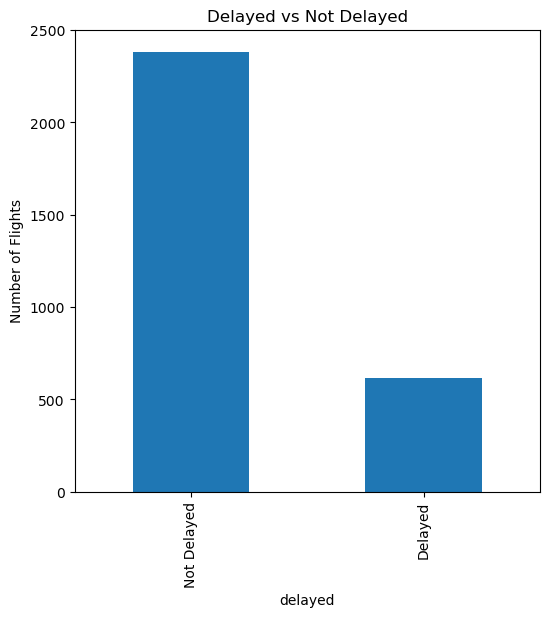

In [29]:
# Define plot characteristics
flight_info_df["delayed"].replace({0: "Not Delayed", 1: "Delayed"}).value_counts().plot(
    kind="bar",
    figsize=(6, 6),
    ylabel="Number of Flights"
)

# Define plot labels
plt.title("Delayed vs Not Delayed")
plt.show()

##### Pie Chart

Lets create a pie chart to visualise the percentage of delayed and not delayed flights in the dataset. This will provide an overview of the distribuition of the target variable in the dataset.

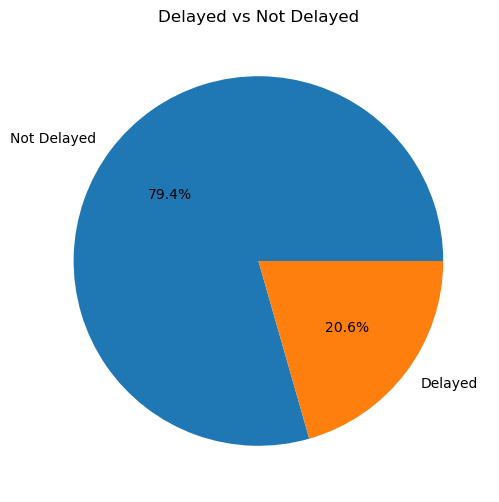

In [30]:
# Define plot characteristics
flight_info_df["delayed"].replace({0: "Not Delayed", 1: "Delayed"}).value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    figsize=(6, 6),
    ylabel=""
)

# Define plot labels
plt.title("Delayed vs Not Delayed")
plt.show()

##### Target Feature Distribution Trends 

The dataset shows a 79.4-20.6 split between non-delayed and delayed flights. This shows a moderate class imbalance, with the vast majority of flights departing on time. While this class imbalance is reflective of the aviation industry, it will have implications on model evaluation. A naive classification model predicting all flights as "not delayed" would achive 80% accuracy. This means that accuracy alone is not a sufficient performance metric and other forms of model evaluation should be used. The class imbalance also suggest models may naturally favour the majority class unless properly regularised or evaluated with appropriate metrics.

#### Trend Visualisations

This section will visualise the important trends in the flight dataset.

Lets define a new dataframe that contains only the flights that were delayed

In [31]:
# Select just delayed flight
delayed_flight_df = flight_info_df.loc[flight_info_df["delayed"] == 1]

##### Departure Delay Duration

Lets create a histogram to visualise the delay duration of delayed flights.

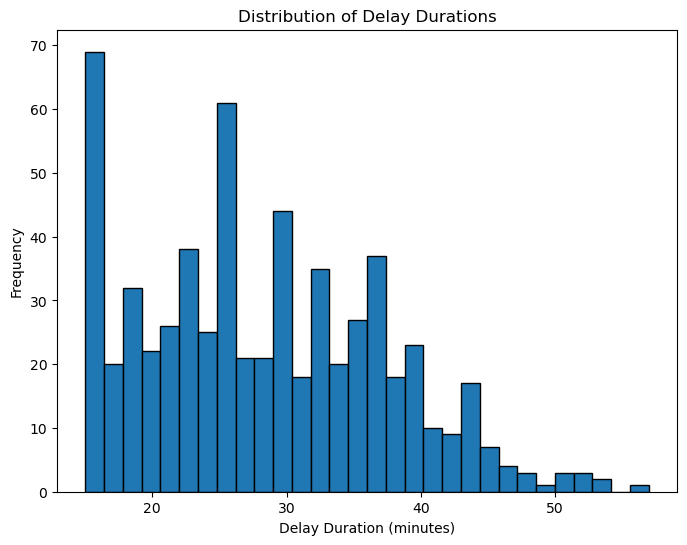

In [32]:
# Departure Delay histogram plot
delays = delayed_flight_df["dep_delay"]

# Define plot characteristics
delays.plot.hist(
    bins=30,
    figsize=(8,6),
    edgecolor="black"
)

# Define plot labels
plt.title("Distribution of Delay Durations")
plt.xlabel("Delay Duration (minutes)")
plt.ylabel("Frequency")
plt.show()

###### Key Trends

- **Right Skewed Distribution**: Most  delayed flights experience short delays (15-30 mins), with the frequency decreasing steadly as delay duration increases.
- **Long-Tail Behaviour**: A smaller number of flights experience significantly longer delays (40-60 mins).
- **High Density near the Minimum Delay Threshold**: The largest bar appears near 15 mins, which alligns with the project brief's definition of a "delay".

###### Interpretations

This indicates that while delays do happen, they tend to be short in duration, and extreme delays are less common.

##### Flight Distance

Lets create a histogram to visualise the flight distance of each delayed flight in the dataset.

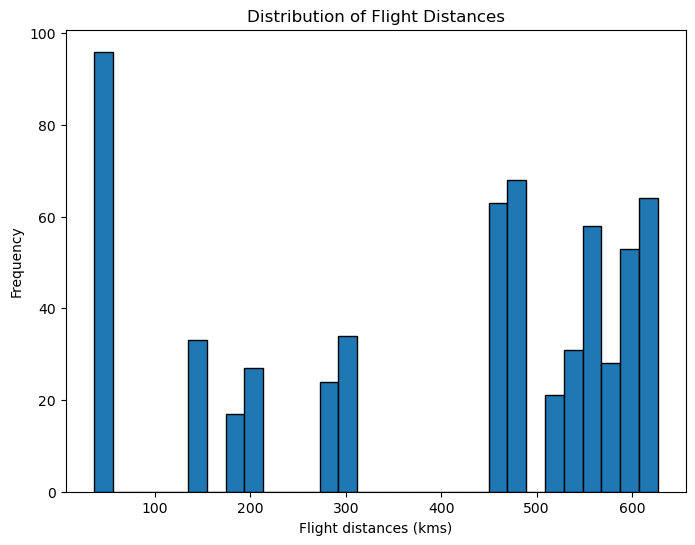

In [33]:
# Get the distances of all the delayed flights
flight_distances = delayed_flight_df["distance_km"]

# Define plot characteristics
flight_distances.plot.hist(
    bins=30,
    figsize=(8,6),
    edgecolor="black"
)
# Define plot labels
plt.title("Distribution of Flight Distances")
plt.xlabel("Flight distances (kms)")
plt.ylabel("Frequency")
plt.show()

###### Key Trends

- **Multimodal Distribution**: The plot shows distinct clusters around certain distance ranges. This is unsurprising since the dataset only contains flight data from flight between Ireland and The United Kingdom.
- **Large Spike at the Shortest Distance Bin**: A very high count appears around the smallest distance group (50-75 kms), suggest heavy traffic on at least one short hall route.
- **Even Distribution in Medium/Long-Range Distances**: Distances in the 450-650 km range appear evenly spread with no single dominant value.

###### Interpretations
Flight operations in this dataset include a mix of distance ranges, with one particular short-haul route dominating traffic volume.

##### Flight Durations

Lets create a histogram to visualise the flight duration (in minutes) of delayed flights.

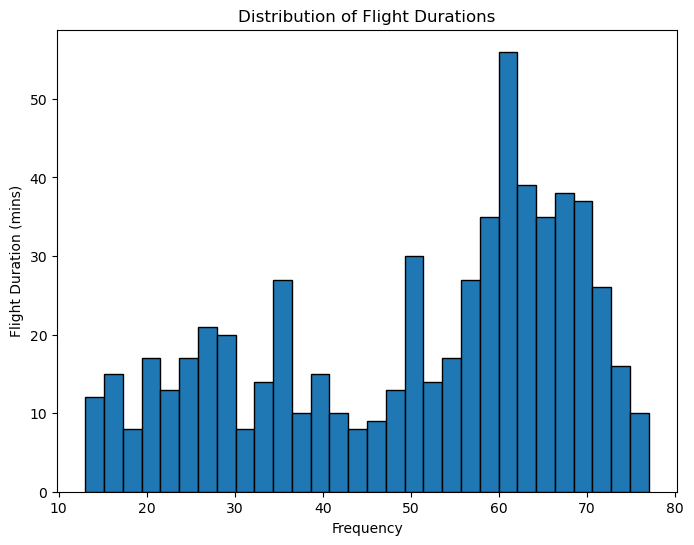

In [34]:
# Flight Duration scatter plot
flight_duration = delayed_flight_df["flight_duration_mins"]

# Define plot characterists
flight_duration.plot.hist(
    bins=30,
    figsize=(8,6),
    edgecolor="black"
)

# Define plot labels
plt.title("Distribution of Flight Durations")
plt.xlabel("Frequency")
plt.ylabel("Flight Duration (mins)")
plt.show()

###### Key Trends

-  **Spike in delays for 58-72 minute flights**: There is a spike in departure delays for flights that last between 58 - 72 minutes.

###### Interpretation:
Most delays occur for on flights that just just below to just above 1 hour.

Lets add a binary column to the dataframe called "likely_flight_duration". Entries in this column will be 1 if the flights duration is between 58 and 72 minutes, 0 otherwise.

In [35]:
# Add new column likely_flight_duration to the flight_info_df dataframe.
# Entries in this column will be 1 if the flights duration is between 58 and 72 minutes, 0 otherwise.

flight_info_df["likely_flight_duration"] = ((flight_info_df["flight_duration_mins"].between(58,72))).astype(int)

##### Wind levels

Lets create a bar chart to visualise the number of delayed flights at each wind level.

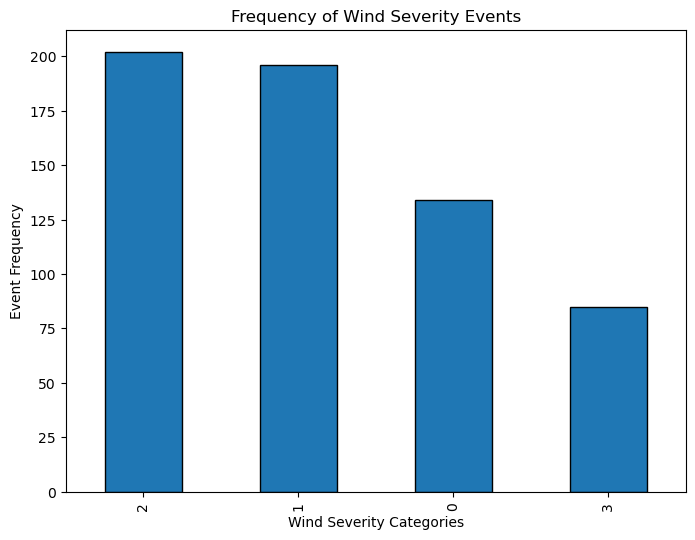

In [36]:
# Grab the number of occurances of each wind category
wind_level_counts = delayed_flight_df["wind"].value_counts()

# Define plot characterists
wind_level_counts.plot.bar(
    figsize=(8,6),
    edgecolor="black"
)

# Define plot labels
plt.title("Frequency of Wind Severity Events")
plt.xlabel("Wind Severity Categories")
plt.ylabel("Event Frequency")
plt.show()

###### Key Trends

- **Breezy and Windy conditions dominate**: Categories 2 (“Windy”) and  1(“Breezy”) are the most frequent of the wind severity events for delayed flights.
- **Strong Wind and Non Wind Conditions are Rare**: Wind level 3 and (“Very Windy”) occurs far less frequently for delayed flights.

###### Interpretation:
There is a clear trend emerging here, delayed flight occur much more frequently during "windy" and "breezy" conditions. Very small amounts of flights are delayed during "Calm" and "Very Windy" conditions.

Lets add a binary column "likely_wind_condition" which represents if a flight operates in a more likely wind condition (2 or 1) for delays. Entries will be 1 if the flight occurs in a likely wind condition, 0 otherwise.

In [37]:
# Add new column likely_wind_condition to the flight_info_df dataframe.
# Entries in this column will be 1 if the wind countions are 2 or 1, 0 otherwise.

flight_info_df["likely_wind_condition"] = (
                            (flight_info_df["wind"].eq(2) |
                            flight_info_df["wind"].eq(1)
                            )).astype(int)

##### Precipitation Levels

Lets create a bar chart to visualise the frequency of departure delays during precipitation events.

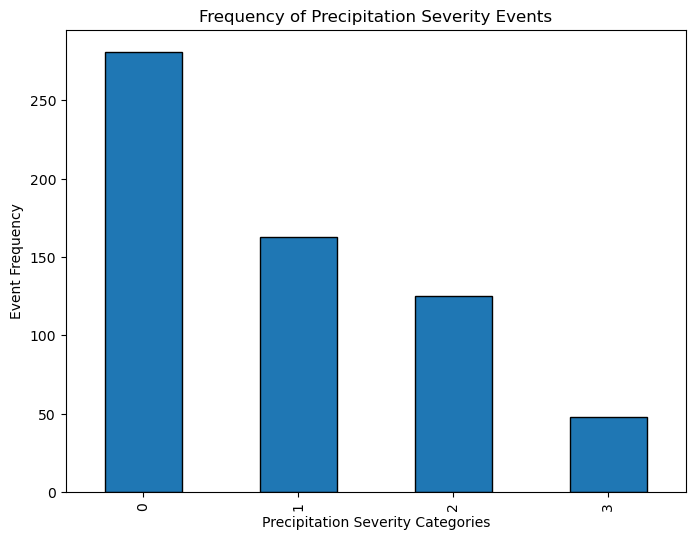

In [38]:
# Grab the number of occurances of each precipitation category
wind_level_counts = delayed_flight_df["precipitation"].value_counts()

# Define plot characterists
wind_level_counts.plot.bar(
    figsize=(8,6),
    edgecolor="black"
)

# Define plot labels
plt.title("Frequency of Precipitation Severity Events")
plt.xlabel("Precipitation Severity Categories")
plt.ylabel("Event Frequency")
plt.show()

###### Key Trends

- **Dry Conditions dominate**: Precipitation level 0 accounts for the majority of observations.
- **Light Precipitation still Common**: Levels 1 and 2 appear noticeably, but far less than 0.
- **Heavy Precipitation is Rare**: Level 3 has a very small count compared to others.


###### Interpretation

This distribution shows that **most delayed flights operate under favourable weather**, with severe precipitation being uncommon.

Lets add new column likely_precipitation_condition to the flight_info_df dataframe. Entries in this column will be 1 if the precipitation condition is equal to 1, 0 otherwise.


In [39]:
# Add new column likely_precipitation_condition to the flight_info_df dataframe.
# Entries in this column will be 1 if the wind countions are 2 or 1, 0 otherwise.

flight_info_df["likely_precipitation_condition"] = ((flight_info_df["precipitation"].eq(0))).astype(int)

##### Hour of Departure Delays

Lets create a histogram to visualise the frequency of departure delays per hour in the dataset.

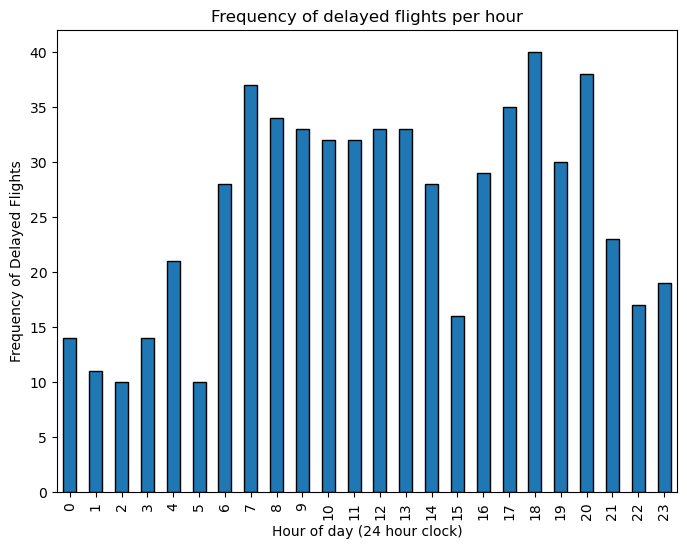

In [40]:
# Count the frequency of delayed flights per hour
frequency_per_hour_of_delayed_flights = delayed_flight_df["departure_hour"].value_counts()

# Sort the returned series based on the index of the series (hour of day)
frequency_per_hour_of_delayed_flights = frequency_per_hour_of_delayed_flights.sort_index()

# Define a bar chart to display the frequency of delayed flights per hour
frequency_per_hour_of_delayed_flights.plot.bar(
    figsize=(8,6),
    edgecolor="black"
)

# Define plot labels
plt.title("Frequency of delayed flights per hour")
plt.xlabel("Hour of day (24 hour clock)")
plt.ylabel("Frequency of Delayed Flights")
plt.show()

##### Key Trends
- **Low Frequency between 0-5**
- **High Frequency between 7am - 2pm**
- **Low Frequency at 3pm**
- **High Frequency between 4pm - 8pm**
- **Low Frequency from 9pm - midnight**

##### Interpretation

There are two identifiable periods 7 - 13 and 16 - 20 that have a higher frequency of delays. This periods extend longer that originally hypothesises (6-9 am and 4-7 pm). 

**Change peak_hour_departure column**

Lets alter the entries in the "peak_hour_departure" column to represent this new trend.

In [41]:
# Change the peak_hour_departure column to 1 if the flight schedules to depart between 7am -2 pm
# or 4-8 pm, 0 otherwise.

flight_info_df["peak_hour_departure"] = ((flight_info_df["departure_hour"].between(7,14)) | 
                                         (flight_info_df["departure_hour"].between(16,20))).astype(int)


##### Day of Departure Delays

Lets create a histogram to visualise the frequency of departure delays per day in the dataset.

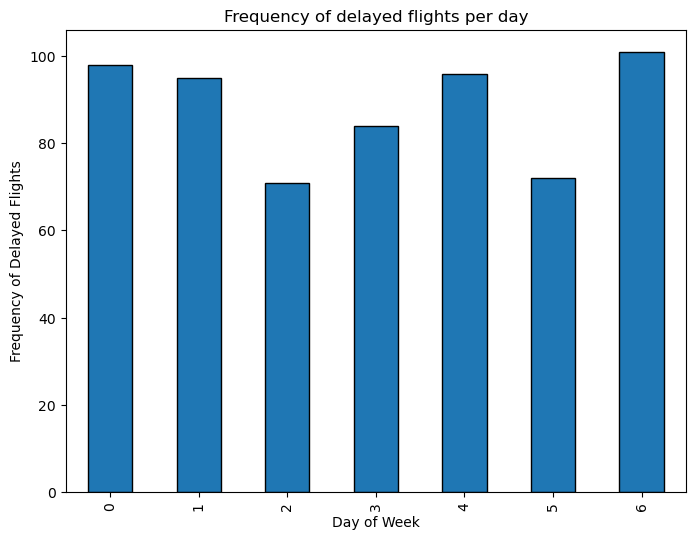

In [42]:
# We can reuse the delayed_flight_df variable from before
delay_frequency_per_day = delayed_flight_df["departure_dayofweek"].value_counts()

# Sort based on the index 1-7 (day of the week)
delay_frequency_per_day = delay_frequency_per_day.sort_index()

# Define Plot
delay_frequency_per_day.plot.bar(
    figsize=(8,6),
    edgecolor="black"
)

# Define plot labels
plt.title("Frequency of delayed flights per day")
plt.xlabel("Day of Week")
plt.ylabel("Frequency of Delayed Flights")
plt.show()

###### Key Trends

Mondays, Tuesdays, Fridays and Sundays have the highest frequency of delays (95-101 range) while Wednesdays, Thursdays and Saturdays have a slightly lower rate (71-84 range).

Lets add a column called "peak_day_departure" that represents if a flight is scheduled to depart on a busy day.

In [43]:
# Create a new peak_day_departure column and set entries to 1 if the flight is scheduled to depart on a "busy day"
# (Mondays, Tuesdays, Fridays and Sundays) or 0 if the flight is scheduled to depart on a "quiet day"
# (Wednesdays, Thursdays and Saturdays)

flight_info_df["peak_day_departure"] = ((flight_info_df["departure_dayofweek"].between(0,1)) | 
                                         (flight_info_df["departure_dayofweek"].eq(4)) | 
                                         (flight_info_df["departure_dayofweek"].eq(6))                                       
                                       ).astype(int)

##### Month of Departure Delays

Lets create a histogram to visualise the frequency of departure delays per month in the dataset.

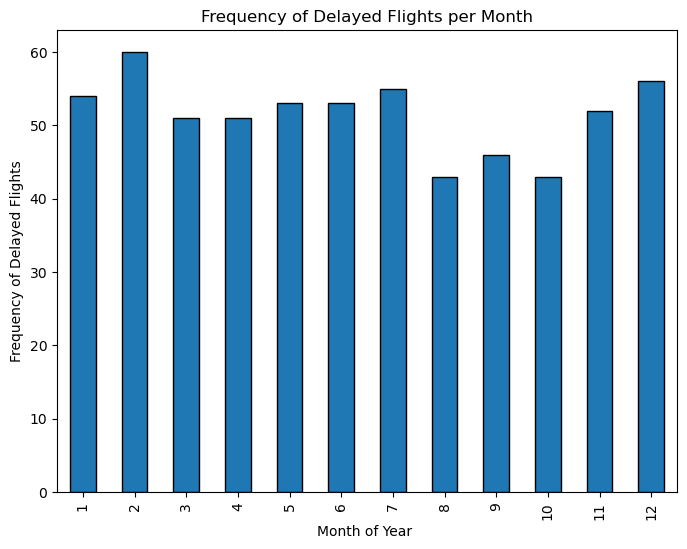

In [44]:
# We can reuse the delayed_flight_df variable from before
delay_frequency_per_month = delayed_flight_df["departure_month"].value_counts()

# Sort the returned series based on the index of the series (Month of Year)
delay_frequency_per_month = delay_frequency_per_month.sort_index()

# Define a bar chart to display the frequency of delayed flights per month
delay_frequency_per_month.plot.bar(
    figsize=(8,6),
    edgecolor="black"
)

# Define plot labels
plt.title("Frequency of Delayed Flights per Month")
plt.xlabel("Month of Year ")
plt.ylabel("Frequency of Delayed Flights")
plt.show()

###### Key Trends

Surprisingly there is no strong trend in the frequency of delayed departures per month.

###### Interpretation

Delay frequency per month fluctuates from a minimum of 43 in August to 60 in February. This range is too small to justify adding new derived features to the dataframe.

##### Overall Interpretaion

Across all visualisations, the data shows:
- The vast majority (79.4%) of flights depart within 15 minutes of their scheduled departure time.
- The dataset contains data from multiple routes.
- Delays tend to be short, with only a minority experiencing significant delays.
- Flight delays are more likely when wind conditions are "Windy" or "Breezy".
- Flight delays are more likely when precipitation conditions are "Dry".
- Flights are more likely to be delayed between 6:00 - 14:00 and 16:00 - 20:00.
- Flights are more likely to be delayed on Mondays, Tuesdays, Fridays and Sundays.

#### New Derived Features

The following Features have either been altered or added to the "flight_info_df" to better represent delay trends in the dataset following the **Visualisation** Section above:
- The binary column **likely_flight_duration** was created. Entries in this column will be 1 if the flights duration is between 58 and 72 minutes, 0 otherwise.
- The binary column **likely_wind_condition** was added to represent if a flight operates in a more likely wind condition (2 or 1) for delays. Entries will be 1 if the flight occurs in a likely wind condition, 0 otherwise.
- The binary column **likely_wind_condition** was created to represent whether a flight operates in a wind condition more likely to cause delays. Entries in this column will be 1 if the precipitation condition is equal to 1, 0 otherwise.
- The **peak_hour_departure** column has been **altered** so entries are 1 if the flight is scheduled to depart between 6:00-14:00 or 16:00-20:00, 0 otherwise.
- The new **peak_day_departure** column was **created** and sets entries to 1 if the flight is scheduled to depart on a "busy day" (Mondays, Tuesdays, Fridays and Sundays) or 0 if the flight is scheduled to depart on a "quiet day" (Wednesdays, Thursdays and Saturdays)

## Task 2: Classification & Evaluation

In [45]:
# Lets quickly import all the necessary libraries to create and evaluate the classification algorithms
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.inspection import permutation_importance

### Classification Algorithm 1: Logistical Regression

**Introduction To Logistical Regression**

Logistical regression is a statistical method for predicting binary classes (e.g "yes" or "no", "True" or "False" etc). Logistical Regression uses a sigmoid function that produces an "s" shaped curve that can take any real-valued number and map it to a value between 0 and 1. If the output of the sigmoid function is > 0.5, the outcome is classified as 1 or Yes, while if the output of the sigmoid function is < 0.5 then, the outcome is classified as 0 or No.

Lets create a Logistical regression model and assess it's performance at classifying departure delays of flights in the dataset.

#### Selecting Features

Lets define the features to use in the logistical regression model.

In [46]:
# Define the list of features to use in the Logistical Regression Model
logistical_regression_feature_columns = [
    "distance_km",
    "likely_flight_duration",
    "precipitation",
    "wind",
    "likely_wind_condition",
    "likely_precipitation_condition",
    "peak_hour_departure",
    "peak_day_departure"
]

#### Define Target Variable and Features

Let's now create two dataframes to represent the target variable and the input features.

In [47]:
# Define the dataframe containing the input features
X = flight_info_df[logistical_regression_feature_columns]

# Define the dataframe containing the target variables.
y = flight_info_df["delayed"]

#### Splitting Data

Lets split the dataset into 80%, to be used to train the model, and 20%, to be used to test and evaluate the model. 

In [48]:
# Define an 80% training set and a 20% testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=16, stratify=y)

#### Scale values

In [49]:
# Initialise standard scaler
scaler = StandardScaler()

# Fit and Transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data
X_test_scaled = scaler.transform(X_test)

#### Model Development and Prediction

Lets now define and train the logistical regression model.

In [50]:
# Define Logisitical Regression Model
logistical_regression_model = LogisticRegression(max_iter=500)

# Fit model to the training data
logistical_regression_model.fit(X_train_scaled, y_train)

# Apply model on the test data
y_pred = logistical_regression_model.predict(X_test_scaled)

#### Logistical Regression Model Evaluation

Lets now describe the evaluation metrics that will be used to evaluate this Logistical Regression Model and all other classification models and detail what they tell us about the performanace of the model.

##### Precision

This metric calculates: "*When a model predicts a class, how often is it correct?*" Lets take the 0 class meaning the flight wasn't delayed, the precision metric tells us what percentage of those predictions were actually correct.

##### Recall

This metric calculates: "*Out of all the true cases of this class, how many did the model correctly find?*". For the delayed class *Recall measures how many of the actual delayed flights your model successfully detected*.

##### f1-score

This metric calculates: A balanced summary of precision and recall.

##### Support

How many actual samples exist for this class in the test set? The smaller the support size, the less reliable the performance metrics will become.

These four metrics can be easily calculated using the **classification_report(...)** method.

In [51]:
print("-------- Delay Classification report --------")
print(classification_report(y_test,y_pred))

-------- Delay Classification report --------
              precision    recall  f1-score   support

           0       0.80      0.99      0.88       477
           1       0.46      0.05      0.09       123

    accuracy                           0.79       600
   macro avg       0.63      0.52      0.49       600
weighted avg       0.73      0.79      0.72       600



##### Confusion Matrix

A confusion matrix shows how your classifier’s predictions compare to the actual truth. For delayed vs not delayed flights, it looks like this:

|                     | Predicted: NotDelayed | Predicted: Delayed |
| :----------------   | :------: | ----: |
| Actual: Not Delayed | True Negative         | False Positive     |
| Actual: Delayed     | False Negative        | True Positive      |

What do each each of the entries in the confusion matrix mean:
- **True Negative**: Flight was predicted not delayed and was actually not delayed.
- **False Negative**: Fligth was predicted not delayed but the flight was actually delayed.
- **True Positve**: Flight was predicted delayed and was delayed.
- **False Positive**: Flight was predicted delayed but was actually not delayed.

Lets now create a confusion matrix for the Logistical Regression classifier.

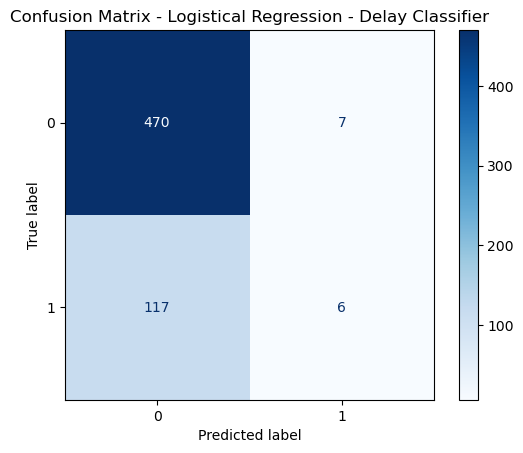

In [52]:
# Create a confusin Matrix 
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=logistical_regression_model.classes_)
target_names = ["No Delay", "Delay"]

# Plot information
confusion_matrix_display.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistical Regression - Delay Classifier")
plt.show()

#### Logistical Regression Evaluation: Interpretation and Insight

The logistic regression model performs well at identifying **non-delayed flights** but struggles significantly with **delayed flights**. This is clear from both the confusion matrix and the metrics of the classification report.

**Key Observations**
- **Class 0 (not delayed)**
    - Very high recall (0.99) and good precision (0.80).
    - The model correctly identifies almost all non-delayed flights (470 out of 477).
- **Class 1 (delayed)**
    - Extremely low recall (0.05): the model only finds 7 of the 134 actual delayed flights.
    - Low precision (0.46), meaning when it predicts a delay, it is only correct about 46% of the time.
    - The F1-score is very poor (0.09), showing the model fails to capture the delayed class.

**Why this happens**:
- The dataset is highly imbalanced, with far more non-delayed flights than delayed ones. Logistic regression tends to favour the majority class unless explicitly corrected.
- Many flight features may not linearly separate delayed and non-delayed flights, which makes logistic regression struggle to find good decision boundaries.
- The model defaults to predicting class 0 because this yields a high overall accuracy (0.79), even though performance on class 1 is poor.

**Takeaway**
The model is reliable for predicting non-delays but not useful for detecting delayed flights. To improve performance, techniques such as class-weighting, SMOTE oversampling could yield better results.

#### Task 3.1: Feature Predictive Power of Logistic Regression Model.

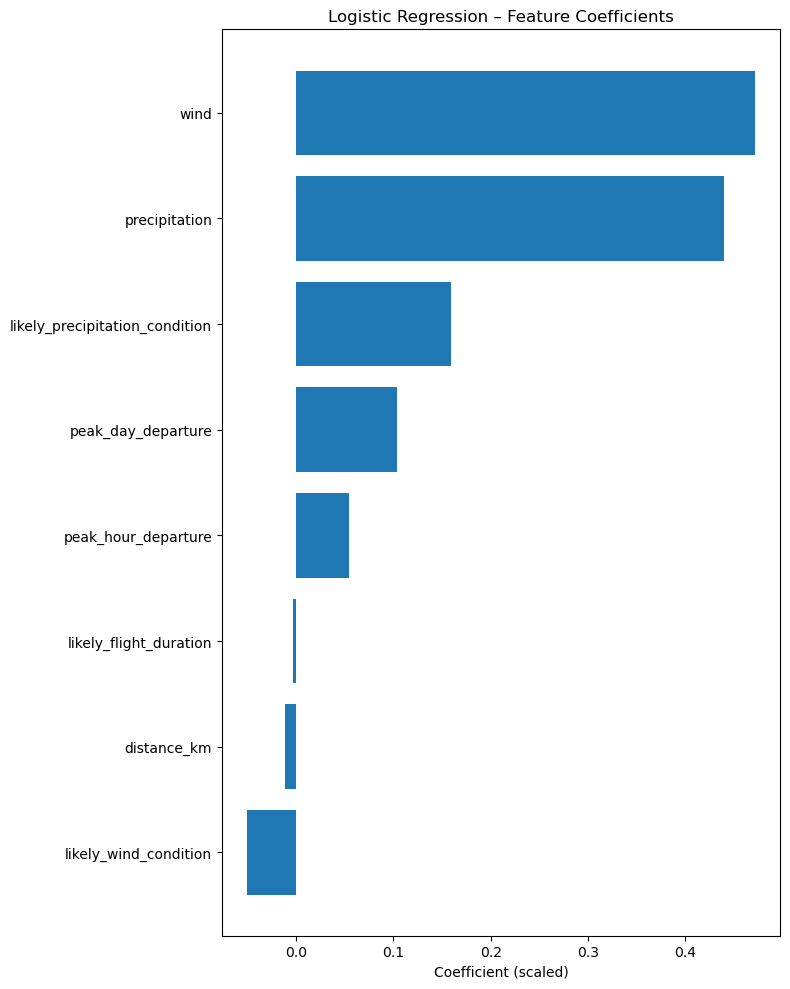

In [53]:
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": logistical_regression_model.coef_[0]
}).sort_values("Coefficient", ascending=True)



plt.figure(figsize=(8, 10))
plt.barh(coef_df["Feature"], coef_df["Coefficient"])
plt.xlabel("Coefficient (scaled)")
plt.title("Logistic Regression – Feature Coefficients")
plt.tight_layout()
plt.show()

In [54]:
coef_df.head(8)

,Feature,Coefficient
4,likely_wind_condition,-0.050225
0,distance_km,-0.011334
1,likely_flight_duration,-0.003504
6,peak_hour_departure,0.054462
7,peak_day_departure,0.103847
5,likely_precipitation_condition,0.158662
2,precipitation,0.439974
3,wind,0.471067


##### Predictive Feature Analysis Using Logistic Regression Coefficients

To examine the predictive value of the features in our dataset,  the scaled coefficients produced by the logistic regression model were analysed. In logistic regression, the size and sign of a coefficient indicate how strongly that feature influences the probability of a flight being delayed. Larger positive coefficients suggest a stronger positive contribution to delay risk, while small or near-zero coefficients indicate low predictive value.

The bar chart of coefficients above highlights clear differences in feature importance:

**Strongest Positive Predictors of Delays**

- **wind** (0.471067) has the largest positive coefficient in the model. This indicates that higher wind levels measured at the origin airport strongly increase the likelihood of departure delays. This is now the single strongest predictor.

- **precipitation** (0.439974) is another major positive predictor. Heavy or persistent precipitation is strongly associated with increased delay risk.

- **likely_precipitation_condition** (0.158662) also contributes positively. This derived indicator suggests that conditions likely to produce precipitation meaningfully increase delay probability, even before actual precipitation is recorded.

- **peak_day_departure** (0.103847) and **peak_hour_departure** (0.054462) have smaller positive coefficients. This suggests that flights scheduled on peak days or during peak hours are more likely to be delayed, possibly due to congestion, operational bottlenecks, or higher traffic loads.

**Weak or Near Zero Predictors**

- **likely_flight_duration** (-0.003504) has a coefficient extremely close to zero, indicating it contributes almost nothing to predicting delay outcomes.

- **distance_km** (-0.011334) also sits very close to zero. This suggests that the flight distance does not play a meaningful role in whether a flight becomes delayed in this dataset.

**Negative Predictor of Delay**

- **likely_wind_condition** (-0.050225) has a small negative coefficient. This means that this derived feature slightly reduces the predicted probability of a delay. The opposite signs for wind and likely_wind_condition may indicate that measured wind has a strong effect, but the derived "likely" flag is not a reliable signal.

**Summary**

Overall, the model relies most heavily on actual weather measurements, particularly wind and precipitation, as the dominant predictors of delay. Operational timing features (peak day and peak hour) also contribute positively, although much less strongly. Other features such as distance and likely flight duration contribute very little, while likely wind condition offers only a weak negative effect.

These results highlight the importance of real weather conditions as the key predictors of delays in the logistic regression models.

### Classification Algorithm 2: K-Nearest Neighbours (KNN) Classification

**Introduction To K-Nearest Neighbours**

K-Nearest Neighbours Classification is a supervised machine learning algorithm used for typically used for classification. It workd by finding the $K$ closed data points (neighbours) to a given input and makes a pridiction based on the majority class. K-Nearest Neighbours works by using proximity and majority voting to make predictions about an input. 

sklearn offers a *KNeighborsClassifier* package which follows the same processes as the linear and logistical regression models that have been performed previously.

####  Selecting Features

Lets select features from the dataset to use as input for the KNN classifer model. 

In [55]:
# Define the list of features to use in the KNN Model
feature_columns = [
    "distance_km",
    "likely_flight_duration",
    "precipitation",
    "wind",
    "likely_wind_condition",
    "likely_precipitation_condition",
    "peak_hour_departure",
    "peak_day_departure"
]

#### Define Target Variable and Features

In [56]:
# Define X as a dataframe containing the features for the KNN classifier.
X = flight_info_df[feature_columns]

# Define the "delayed" column as the target variable we wish to predict.
y = flight_info_df["delayed"]

#### Splitting Data

In [57]:
# Lets split the dataset for training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

#### Scale Numeric Features

In [58]:
# Scale the features using a standard scaler object.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Train the KNN Model

In [59]:
# Define a KNN Classification Model with K = 5
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model to the training data.
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

#### Make Prediction using the Test Data  

In [60]:
# Use the KNN classifier to predict departure delays.
y_pred = knn.predict(X_test_scaled)

#### Model Evaluation

Since the KNN model is used for classification, lets use the same maetric as the Logistical Regression model namely:
- Precision
- Recall
- f1-Score
- Support
- Confusion Matrix
- Accuracy

##### Classification Report Evaluation

In [61]:
print("----------------- Delay Classification Report -----------------")
print(classification_report(y_test, y_pred))

----------------- Delay Classification Report -----------------
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       477
           1       0.30      0.15      0.20       123

    accuracy                           0.76       600
   macro avg       0.55      0.53      0.53       600
weighted avg       0.70      0.76      0.72       600



##### Confusion Matrix

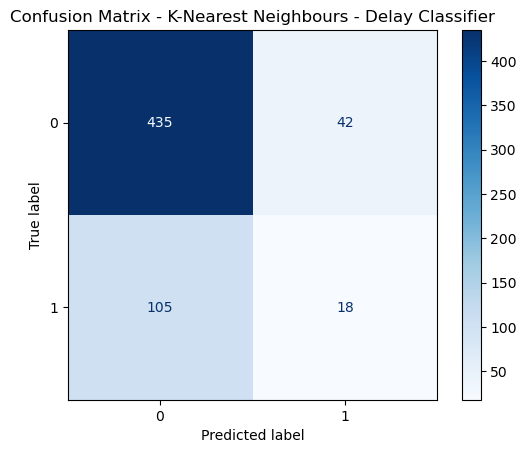

In [62]:
confusion_matrix_display =  ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred), display_labels=knn.classes_)
target_names = ["No Delay", "Delay"]
confusion_matrix_display.plot(cmap="Blues")
plt.title("Confusion Matrix - K-Nearest Neighbours - Delay Classifier")
plt.show()

##### K-Nearest Neighbours Evaluation: Interpretation and Insight

The KNN model shows behaviour similar to the Logistical Regression classifier: it performs well at predicting non-delayed flights, but it struggles to correctly identify delayed flights, reflecting the imbalance in the dataset.

**Key Observations**
- **Class 0 (Not Delayed)**
    - **Recall: 0.91** - The model correctly identifies 435 out of 477 non-delayed flights.
    - **Precision: 0.81** - Most predictions of “not delayed” are correct.
    - **F1-score: 0.86** - Strong overall performance on the majority class.
    - This shows the model is reliable at ruling out delays when a flight is genuinely on time.
- **Class 1 (delayed)**
    - **Recall: 0.15** - Only 18 of 123 delayed flights are detected.
    - **Precision: 0.30** - Many flights predicted as delayed are actually non-delayed.
    - **F1-score: 0.20** - Confirms weak performance on identifying delays.
    - The confusion matrix highlights this clearly: 105 delayed flights were misclassified as on-time.

**Why does this happen**

- Imbalanced dataset.
- KNN relies on majority voting among neighbours; since most neighbours belong to class 0, the algorithm tends to favour the majority class.
- The feature space may not clearly separate delayed and non-delayed flights, causing overlapping clusters.

**Takeaways**
KNN is effective at predicting non-delayed flights but performs poorly on detecting delays. This weakness is tied directly to class imbalance and the structure of KNN. Improving minority class performance would require techniques such as oversampling (SMOTE), reducing K, adjusting distance weights, or using models more robust to imbalance like decision trees or random forests.


##### Cross Validation to Get the Best Value of K

Cross Validation evaluates different values of K to identify which one gives the most reliable performance for the KNN model. By testing multiple K values and comparing their validation scores, it avoids arbitrary selection and ensures the final model uses the most effective level of neighbourhood smoothing. This helps prevent underfitting or overfitting and leads to a more balanced model.

In [64]:
# Define the range of K values to test (from 1 to 20)k
k_values = range(1, 21)
cv_scores = []


# Loop through each possible K value creating a new model each time
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    cv_scores.append(scores.mean())

# Find the K value with the highest cross-validation accuracy
optimal_k = k_values[np.argmax(cv_scores)]
print("Best K =", optimal_k)

Best K = 16


##### Plot Cross Validation Scores

Text(0.5, 1.0, 'Accuracy Scores for Different Number of Nearest Neighbours')

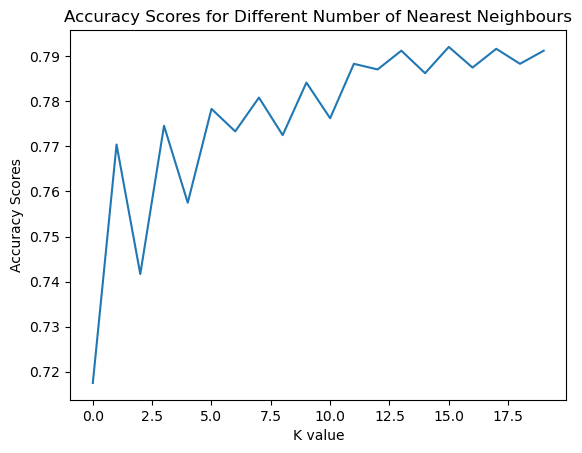

In [65]:
plt.figure()
plt.plot(cv_scores)
plt.ylabel("Accuracy Scores")
plt.xlabel("K value")
plt.title("Accuracy Scores for Different Number of Nearest Neighbours")

##### Model Re-Training

Now that we know that the model is more accurate with $K=16$ lets retrain the KNN classifier model using this new parameter.

In [66]:
# Define new KNN classifer model with optimised value for K
knn = KNeighborsClassifier(n_neighbors=optimal_k)

# Fit the model to the training data
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=16)

##### Make New Predictions Using the New KNN Model.  

In [67]:
# Use the new KNN classifier to predict departure delays.
y_pred = knn.predict(X_test_scaled)

##### Output Metrics

In [68]:
print("----------------- Delay Classification Report -----------------")
print(classification_report(y_test, y_pred))

----------------- Delay Classification Report -----------------
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       477
           1       0.75      0.05      0.09       123

    accuracy                           0.80       600
   macro avg       0.78      0.52      0.49       600
weighted avg       0.79      0.80      0.73       600



##### New Confusion Matrix 

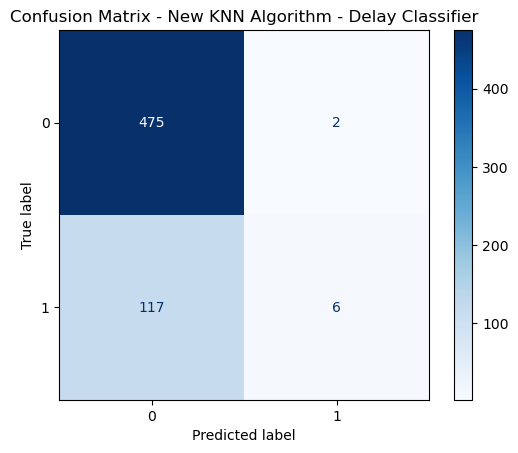

In [69]:
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=knn.classes_)
confusion_matrix_display.plot(cmap="Blues")
plt.title("Confusion Matrix - New KNN Algorithm - Delay Classifier")
plt.show()

#### K-Nearest Neighbours Evaluation: Interpretation and Insight

The KNN model shows very similar behaviour to the logistic regression model: it predicts **non-delayed flights** well but struggles to correctly identify **delayed flights**.

**Key Observations**
- **Class 0 (not delayed)**
    - Very high recall (0.99), meaning almost all non-delayed flights are correctly identified (473 out of 477).
    - Good precision (0.80), showing that most predictions of "not delayed" are correct.
    - Strong overall performance for this majority class.
- **Class 1 (delayed)**
    - Very low recall (0.02): only 3 of the 123 delayed flights are detected.
    - Low precision (0.43), meaning KNN often mislabels non-delays as delays.
    - The F1-score (0.05) confirms weak performance on the minority class.

**Why this happens**:
- Like logistic regression, KNN is affected by the imbalanced dataset where delayed flights are much less common.
- KNN classifies new samples based on the most common label among their nearest neighbours. Because most neighbours belong to class 0, the algorithm almost always predicts non-delay.
- The features may not provide enough clear separation between delayed and non-delayed flights, causing KNN to cluster heavily around the majority class.

**Takeaway**
KNN performs very well for predicting non-delays but is not effective at detecting delayed flights. This reflects the imbalance in the dataset and the nature of KNN, which tends to follow the majority class. To improve detection of delays, techniques like oversampling the minority class, adjusting class weights, or switching to a model less sensitive to imbalance (e.g., decision trees or random forests) would be beneficial.

#### K-Nearest Neighbours Evaluation: Optimised vs Non-Optimised Value for K

The optimised KNN model shows a notable improvement compared to the original version that used an arbitrary K value of 5. The recall for class 0 (non-delayed flights) has increased to 1.00, meaning the classifier now correctly identifies almost every on-time flight. Precision for class 1 (delayed flights) has also improved from 0.30 to 0.75, showing that when the model does predict a delay, it is correct more often. However, the recall for delays remains very low at 0.05, only slightly improving from the earlier 0.15. This suggests that the optimised model has become even more conservative, choosing to classify almost everything as non-delayed.

These results occur because the optimal K, selected through cross-validation, smooths the decision boundary more heavily than K=5. With a higher K value, the model relies on a broader neighbourhood, causing minority-class points (delays) to be dominated by the surrounding majority class (non-delays). This leads to excellent performance on the majority class but worsens the model’s ability to detect rare delay cases. In imbalanced datasets like this one, increasing K tends to favour the majority class, explaining why accuracy improves while recall for delays collapses.

#### Task 3.2: Feature Predictive Power of K-Neareset Neighbours Model.

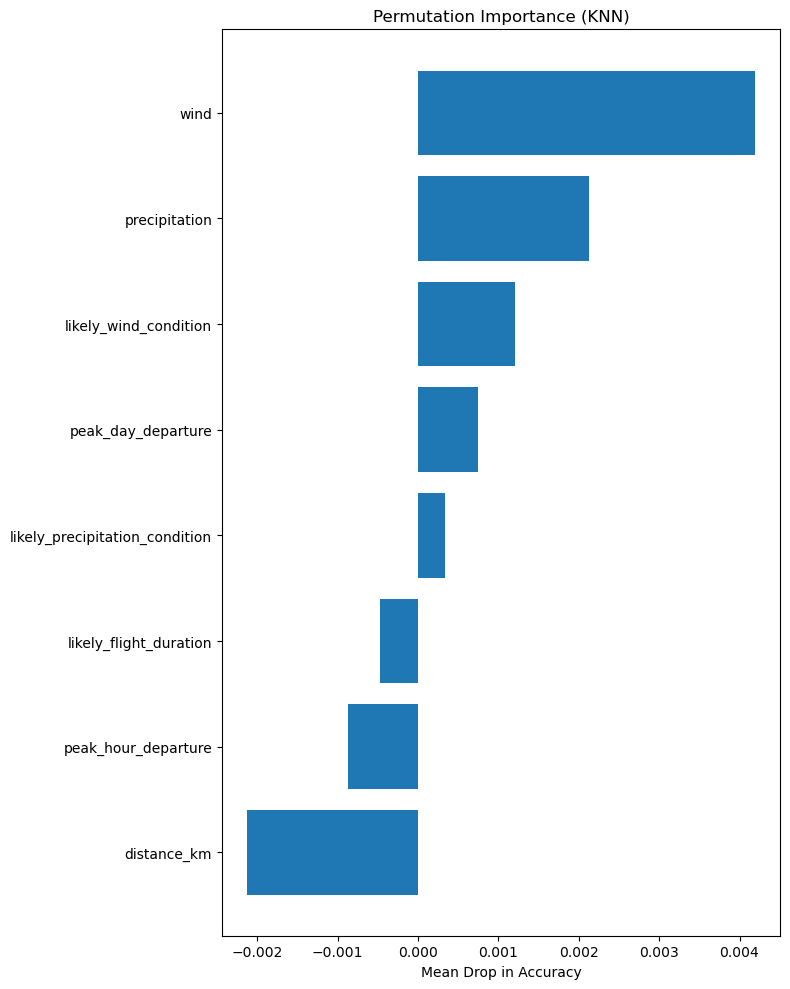

In [70]:
perm = permutation_importance(
    knn, X_train_scaled, y_train,
    n_repeats=20,
    random_state=42
)

perm_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": perm.importances_mean
}).sort_values("Importance", ascending=True)

plt.figure(figsize=(8,10))
plt.barh(perm_df["Feature"], perm_df["Importance"])
plt.xlabel("Mean Drop in Accuracy")
plt.title("Permutation Importance (KNN)")
plt.tight_layout()
plt.show()

In [71]:
perm_df.head(8)

,Feature,Importance
0,distance_km,-0.002125
6,peak_hour_departure,-0.000875
1,likely_flight_duration,-0.000479
5,likely_precipitation_condition,0.000333
7,peak_day_departure,0.000750
4,likely_wind_condition,0.001208
2,precipitation,0.002125
3,wind,0.004187


##### Predictive Feature Analysis Using KNN Permutation Importance

To examine which features contribute most to the predictive ability of the KNN classifier, permutation importance was applied. Unlike logistic regression, KNN does not learn coefficients. Instead, its feature importance is assessed by measuring how much the model’s accuracy drops when each feature is randomly shuffled. A larger positive value indicates a stronger contribution to prediction performance, while values close to zero suggest very limited influence.

The permutation importance results show the following patterns:

**Most Predictive Features**

- **wind** (0.004187) has the highest importance score, meaning it is the most influential feature for KNN when predicting delays. Shuffling wind measurements causes the largest drop in accuracy, indicating that actual wind levels play a meaningful role in how KNN forms its nearest-neighbour relationships.

- **precipitation** (0.002125) is the second most important feature. This reflects that rainfall or snow also affects the KNN’s ability to distinguish delayed flights from non-delayed ones.

- **likely_wind_condition** (0.001208) provides a small but positive contribution. Although weak compared to measured weather variables, this derived indicator still helps KNN capture some weather-related patterns.

- **peak_day_departure** (0.000750) also adds a minor positive effect, suggesting slight differences in delay patterns across busy and non-busy days.

  
**Very Low Predictors**
- **likely_precipitation_condition** (0.000333) has only a minimal impact, indicating that this derived feature adds little additional signal beyond the actual precipitation measurements.

- **likely_flight_duration** (-0.000479), peak_hour_departure (-0.000875), and distance_km (-0.002125) all have near-zero or slightly negative values. Negative permutation scores typically mean that shuffling the feature accidentally introduced noise that helped the model, which usually implies that the feature carries no meaningful predictive information for the KNN classifier.

**Summary**
Overall, the KNN model relies most heavily on actual weather measurements, especially wind and precipitation to make accurate predictions. Derived weather indicators contribute very weakly, while distance and flight duration provide virtually no predictive benefit. Compared to logistic regression, the strengths and weaknesses of the features are broadly similar, although the magnitude of effects is much smaller due to the nature of permutation importance. These results reinforce the conclusion that weather factors are the primary drivers of predictive performance across models.

### Classification Algorithm 3: Decision Trees Classification

**Introduction To Decision Trees**

A decision tree is a simple classification model that predicts an outcome by repeatedly splitting the data based on the most informative features. In this assignment, a decision tree can be trained on flight schedule and weather variables to classify flights as delayed or not delayed. The model learns rules such as “if wind is high and precipitation is high, predict delayed,” making it well suited for capturing non-linear relationships between conditions and delays. Because decision trees are easy to understand and handle both numerical and categorical data, they provide a clear baseline classifier and useful insights into which features contribute most to predicting flight delays.

Using sklearn it is possible to implement a decision tree classifier model in a similiar way to the regression and nearest neighbour models used previously.

#### Define Features

In [72]:
# Define features to be used in the decision tree classifier.
feature_columns = [
    "distance_km",
    "likely_flight_duration",
    "precipitation",
    "wind",
    "likely_wind_condition",
    "likely_precipitation_condition",
    "peak_hour_departure",
    "peak_day_departure"
]

#### Define Features and Target Variable

In [73]:
# Define X as a dataframe containing the features 
X = flight_info_df[feature_columns]

# Define y as a dataframe containing the target variable.
y = flight_info_df["delayed"]

#### Split Data

In [74]:
# Create and 80/20 train, test split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

#### Train the Decision Tree Model

In [75]:
# Define a Decision Tree Model
dt = DecisionTreeClassifier(
    criterion="gini",     # or "entropy"
    max_depth=None,       # allow full depth
    random_state=42
)

# Fit the model to the training data.
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

#### Make Prediction using the Test Data

In [76]:
# Use the Decision Tree classifier to predict departure delays
y_pred = dt.predict(X_test)

#### Model Evaluation

Since the Decision Tree model is used for classification, lets use the same maetric as the Logistical Regression and KNN models namely:
- Precision
- Recall
- f1-Score
- Support
- Confusion Matrix
- Accuracy

##### Classification Report

In [77]:
# Output Model Evaluation Metrics precision, recall, f1-score, support and, accuracy. 
print("----------------- Delay Classification Report -----------------")
print(classification_report(y_test, y_pred))

----------------- Delay Classification Report -----------------
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       477
           1       0.28      0.14      0.19       123

    accuracy                           0.75       600
   macro avg       0.54      0.52      0.52       600
weighted avg       0.70      0.75      0.72       600



##### Confusion Matrix

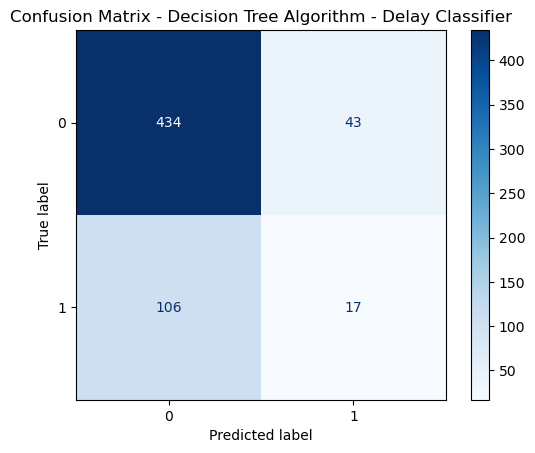

In [78]:
# Ourput the confusion matrix of the Decision Tree Model
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=dt.classes_)
confusion_matrix_display.plot(cmap="Blues")
plt.title("Confusion Matrix - Decision Tree Algorithm - Delay Classifier")
plt.show()

#### Decision Tree Evaluation: Interpretation and Insight

The decision tree performs better than both logistic regression and KNN at identifying **delayed flights**, although its overall accuracy is slightly lower. Unlike the previous models, the tree captures more of the minority class, showing that it handles class imbalance somewhat better.

**Key Observations**
- **Class 0 (not delayed)**
    - Recall of 0.91: the model correctly identifies most non-delayed flights (434 out of 477), but it misclassifies more of them than earlier models.
    - Precision of 0.80 indicates that most predictions of "not delayed" are still correct.
    - Slightly weaker performance on this majority class compared with previous models.
- **Class 1 (delayed)**
    - Recall improves to 0.14 (17 out of 123 correctly identified), which is substantially higher than logistic regression and KNN.
    - Precision is low (0.28), meaning the model generates many false positives.
    - The F1-score (0.19) reflects that the model is still struggling with the minority class, but it is performing **better than the other algorithms**.

**Why this happens**:
- Decision trees are able to capture non-linear relationships and complex interactions between features, which helps them find pockets of delayed flights better than linear or distance-based models.
- However, the dataset is still heavily imbalanced, so the tree remains biased toward predicting non-delays.
- The tree becomes less confident overall, leading to a larger number of false positives and lower accuracy (0.75).

**Takeaway**
The decision tree shows a clear improvement in detecting delayed flights compared with logistic regression and KNN, demonstrating its ability to handle more complex patterns. However, it still struggles with class imbalance and produces many false positives. Techniques such as adjusting class weights, pruning, or using an ensemble method like Random Forests could further improve its performance.

#### Task 3.3: Feature Predictive Power of Decision Tree Model.

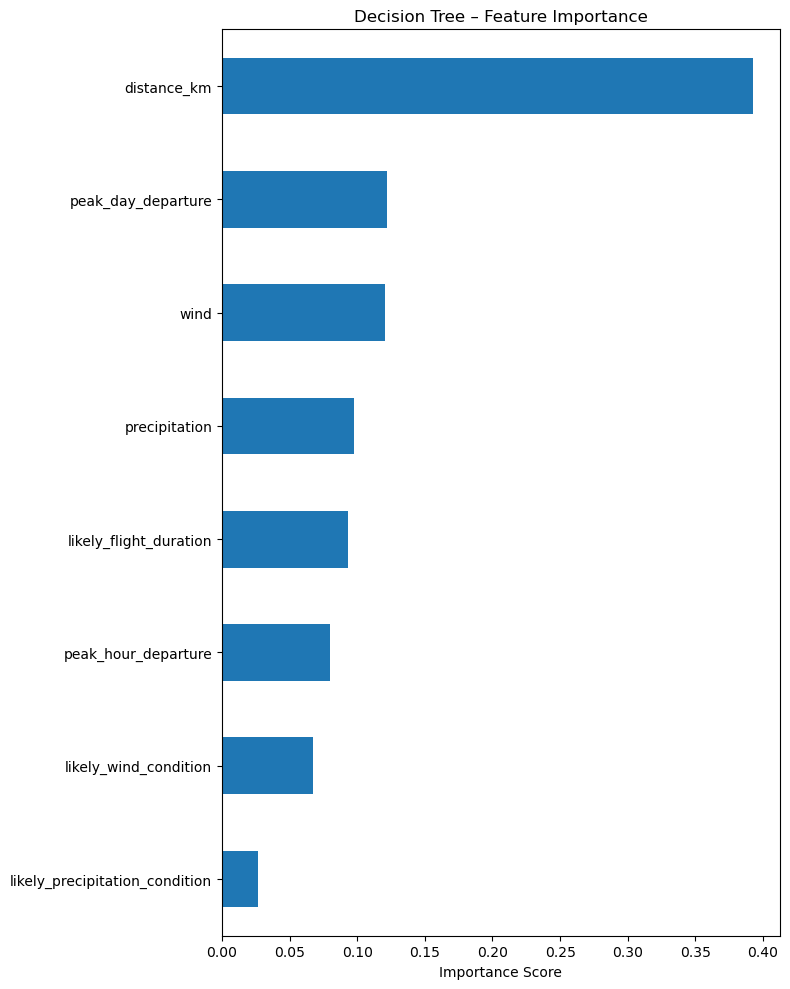

In [79]:
# Store and sort importances
dt_importance = pd.Series(dt.feature_importances_, index=X.columns).sort_values()

plt.figure(figsize=(8, 10))
dt_importance.plot(kind="barh")
plt.title("Decision Tree – Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [80]:
dt_importance.head(8)

likely_precipitation_condition    0.026392
likely_wind_condition             0.067192
peak_hour_departure               0.080142
likely_flight_duration            0.093413
precipitation                     0.097440
wind                              0.120588
peak_day_departure                0.121997
distance_km                       0.392836
dtype: float64

##### Predictive Feature Analysis Using Decision Tree Feature Importance

To understand which features the Decision Tree model relies on most when classifying delayed flights, the built-in feature importance scores were examined. Unlike logistic regression coefficients or permutation importance values, Decision Tree importances measure how much each feature reduces impurity (Gini impurity or entropy) across all splits in the tree. Higher values indicate that the feature is used more frequently and more effectively to make informative splits in the model.

Based on the importance scores, the following patterns emerge:

**Most Influencial Predictors**

- **distance_km** (0.392836) is by far the most important feature in the Decision Tree model. This suggests that route distance plays a major role in how the tree separates delayed and non-delayed flights, possibly because longer routes produce more distinct patterns in the dataset for the model to exploit.

- **peak_day_departure** (0.121997) and **wind** (0.120588) both show strong importance values. This indicates that departures on peak days and measured wind conditions contribute meaningfully to the tree’s decision-making. Wind in particular is consistent with other models, again highlighting its relevance to flight delays.

- **precipitation** (0.097440) also shows moderate importance. This reflects that rainfall or snow provides useful information for splitting the data into delay vs. non-delay classes.

**Moderately Important Features**

- **likely_flight_duration** (0.093413) and **peak_hour_departure** (0.080142) both contribute at a moderate importance level. This indicates that the Decision Tree uses these operational and duration-related features in meaningful ways, even though they played much smaller roles in the KNN and logistic regression models.

- **likely_wind_condition** (0.067192) and **likely_precipitation_condition** (0.026392) have lower but still non-negligible importance values, suggesting that derived weather indicators contribute to some of the tree’s splitting decisions, though they are far less influential than the corresponding measured values.

**Summary**
Overall, the Decision Tree model assigns the greatest importance to distance, followed by a mixture of weather-related variables (wind and precipitation) and scheduling indicators (peak day and peak hour). In contrast to logistic regression and KNN, which found distance to be weak or nearly irrelevant, the Decision Tree identifies distance as its most powerful splitting feature. This highlights an important point: tree-based models can capture nonlinear patterns and interactions that are not visible to linear or distance-based models. Despite these differences, wind and precipitation remain consistently strong predictors across all models, reinforcing the central role of weather conditions in determining departure delays.

## Conclusion


This project provided a structured exploration of flight delay prediction. This project is split into three tasks:

**Data Preparation and Characterisation**

Two datasets were merged and several derived features were created, including indicators for peak departure times and weather conditions likely to cause delays. These additional variables helped capture operational and environmental factors that were not immediately obvious in the raw data. Characterisation of the combined dataset revealed clear trends, most notably the imbalance between delayed and non-delayed flights and the strong association between adverse weather conditions and longer departure delays.

**Classification and Evaluation**

Three models were applied: Logistic Regression, K-Nearest Neighbours, and a Decision Tree classifier. Logistic Regression performed reliably and provided clear interpretability through its coefficients but struggled with complex relationships. KNN handled the non-linear structure of the data better but lacked interpretability and was sensitive to feature scaling. The Decision Tree model captured interactions and non-linear effects effectively, though it was more prone to overfitting and required careful tuning to generalise well. Overall, no single model excelled universally, but each offered distinct strengths.

**Predictive Feature Analysis**

This section highlighted that different models prioritise different types of features. Weather variables such as wind and precipitation consistently appeared influential, but the Decision Tree uniquely identified distance as highly important. Using coefficients, permutation importance, and tree impurity measures provided a justified, model-appropriate framework for comparing predictive feature influence. 


In future work, more advanced ensemble methods or additional feature engineering could help reconcile these differences and improve both performance and interpretability.

## Limitations and Future Work

Although this project demonstrated meaningful insights, limitations remain. The dataset is synthetic and may not fully capture real-world operational variability. Some derived features, such as likely conditions, contributed weakly and could be refined. Future work could incorporate temporal features, or additional data sources such as airport traffic volumes to enhance model accuracy and generalisability. Furthermore, the same set of input features was used for each model, in future work these input features could be fine-tuned to suit the individual classification models which would no doubt result in better model performance.

## GenAI Declaration

GenAI was used in the development of this project in the following ways:
- Code comment generation.
- Markdown cell formatting.
- Code Debugging